In [1]:
import sys,os
sys.path.append("../")

import pandas as pd
import numpy as np
import pickle
import itertools
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import pairwise_distances  
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import entropy
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Reading the change object and clustering.

In [2]:
article_name = "John_Logie_Baird"
change_object_dir =  "../data/change objects/"

change_object_file_name = f"{article_name}_vec.npz"
filename =  f"{article_name}_change.h5"

change_object_file = os.path.join(change_object_dir, filename)

content_dir = "../data/content/"

filename = article_name + ".h5"
filepath = os.path.join(content_dir, filename)
with pd.HDFStore(filepath, 'r') as store:
    token_string_df = store.get("all_tokens")
    
token_string_df = token_string_df.set_index("token_id")["str"]
token_string_df[-1] = "St@rt"
token_string_df[-2] = "$nd"
change_vector_dir = "../data/change_vector/"
change_vec_filename = f"{article_name}.npz"
change_vector_file = os.path.join(change_vector_dir, change_vec_filename)

content_dir = "../data/content/"
len_file = article_name + "_rev_len.h5"
len_file_path = os.path.join(content_dir, len_file)


if os.path.exists(change_object_file):
    with pd.HDFStore(change_object_file, 'r') as store:
        change_object_dataframe = store.get("data")
else:
    print("file do not exist")
    
    


change_object_dataframe["del_string_tokens"] = change_object_dataframe["del_tokens"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist()))

change_object_dataframe["ins_string_tokens"] = change_object_dataframe["ins_tokens"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist()))

change_object_dataframe["edit_string_tokens"] = change_object_dataframe["ins_string_tokens"] + change_object_dataframe["del_string_tokens"]


# rev_len_df = pd.read_hdf(len_file_path, key = "rev_len")
vectors ={}

with open(change_vector_file, "rb") as file:
    arrays_dict = np.load(file)
    vectors[2] = arrays_dict["2_clean_not_weighted"]
    vectors[4] = arrays_dict["4_clean_not_weighted"]
    vectors[6] = arrays_dict["6_clean_not_weighted"]
    vectors[8] = arrays_dict["8_clean_not_weighted"]
    vectors[10] = arrays_dict["10_clean_not_weighted"]
    vectors[12] = arrays_dict["12_clean_not_weighted"]
    vectors[15] = arrays_dict["15_clean_not_weighted"]
    vectors[20] = arrays_dict["20_clean_not_weighted"]
    vectors[25] = arrays_dict["25_clean_not_weighted"]
    vectors[30] = arrays_dict["30_clean_not_weighted"]

#### read annotations

In [3]:
file_name = article_name + "_FULL.csv"
annotation_dir = "../data/annotation/"
full_file_path = os.path.join(annotation_dir, file_name)
annotation_df = pd.read_csv(full_file_path)
annotation_df = annotation_df[["revid_ctxt", "token_id",
                               "rev_id", "nationality", "birth_place", "Bulk" ]]

### clustering


In [4]:
vector_names = list(vectors.keys())
context_array  = vector_names
eps_array = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3, 4]

min_samples_array = [2]
all_combinations = list(itertools.product(context_array, eps_array,
                                          min_samples_array))
dbscan_params = list(itertools.product(eps_array,min_samples_array))
idx = pd.MultiIndex.from_product([context_array, eps_array,min_samples_array],
                                names=["context","eps","min_samples"])
cluster_df = pd.DataFrame(columns=idx)

evaluation_df = pd.DataFrame(index=idx, columns=[])



In [5]:
%%time 
for cluster_by in vector_names:
    distances = pairwise_distances(vectors[cluster_by])
    for eps, min_samples in dbscan_params:
        cluster_df[cluster_by,eps, min_samples] = DBSCAN(eps=eps, min_samples=min_samples, 
                                                         metric="precomputed").fit(distances).labels_

CPU times: user 1min 52s, sys: 1min 6s, total: 2min 59s
Wall time: 1min 41s


In [6]:
def weighted_token_entropy(dataframe, group_by):
    cluster_sizes = dataframe.groupby(group_by).size()
    token_entropy_clusters = dataframe.groupby(group_by)["edit_string_tokens"].apply(
                    lambda token_tuples: entropy(pd.Series(
                    [token for token_tuple in token_tuples.tolist() for token in token_tuple]
                    ).value_counts().values))
    cluster_entropy = (cluster_sizes * token_entropy_clusters).sum()
    return cluster_entropy

In [7]:
cluster_df.index = change_object_dataframe.index
dbscan_results = pd.concat([change_object_dataframe, cluster_df], axis=1)

In [8]:
%%time
# entropy_series = pd.Series(index=all_combinations)

for context, eps, min_samples in all_combinations:
    evaluation_df.loc[(context, eps, min_samples),"token_entropy"] = weighted_token_entropy(dbscan_results, (context, eps, min_samples))
# all_combinations_without_optimization[0]

CPU times: user 2min 20s, sys: 0 ns, total: 2min 20s
Wall time: 2min 20s


#### Splitting change object to match annotations

In [9]:
# insert array is always done in to revision so taking it and leaving other change object where 
ins_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["ins_start_pos"].values != -1, 
                  ["to revision id","ins_tokens", 'to revision id']].values
ins_cluster = cluster_df.loc[
    change_object_dataframe["ins_start_pos"].values != -1, :]

# delete array is always done in from revision so taking it and leaving other change object where delete does not come.
del_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["del_start_pos"].values != -1, 
                  ["from revision id","del_tokens", 'to revision id']].values
del_cluster = cluster_df.loc[
    change_object_dataframe["del_start_pos"].values != -1, :]

gap_array = np.concatenate([ins_array,del_array], axis=0)
gap_df = pd.DataFrame(gap_array,columns=["revid_ctxt", "token_id",
                               "rev_id"])

gap_cluster= pd.concat([ins_cluster, del_cluster], axis=0)
gap_df = gap_df.set_index(['revid_ctxt', 'rev_id'])
gap_cluster_df = pd.concat([ins_cluster, del_cluster], axis=0)

gap_cluster_df.index=gap_df.index

In [10]:
def token_in_gap(ann, gap_df, gap_cluster_df):
    context_gap = gap_df.loc[ann[['revid_ctxt', 'rev_id']]]
    context_cluster = gap_cluster_df.loc[ann[['revid_ctxt', 'rev_id']]]
    clusters = context_cluster.loc[ context_gap["token_id"].apply(
            lambda x: ann["token_id"] in x),:].values
    if clusters.size >0:
            clusters = pd.Series(clusters[0],index=gap_cluster_df.columns)
    else:
        clusters = pd.Series(-10, index=gap_cluster_df.columns)
    return clusters

In [11]:
def weighted_entropy(dataframe, entropy_column, group_columns="cluster", ):
    group_size = dataframe.groupby(group_columns).size()
    group_entropy = dataframe.groupby(group_columns)[entropy_column].apply(lambda x: entropy(x.value_counts().values))
    weighted_entropy = (group_size * group_entropy).mean()
    return weighted_entropy

In [12]:
# Finding the tokens who were in the gap.
al_combination_clusters_df = annotation_df.apply(token_in_gap, axis=1, args=(gap_df, gap_cluster_df))

In [13]:
annotation_clusters = pd.concat([annotation_df, al_combination_clusters_df], axis=1)

In [14]:
true_labels = np.zeros((annotation_df.shape[0]))
true_labels[(annotation_df["nationality"].str.strip() == "Y").values] = 1
annotation_df["nationality"] = true_labels
#true_labels[true_lable_df["birth_place"].str.strip() == "Y"] = 2


# Calculating the entropy of the Annotated change objects

In [15]:
df2 = gap_df.copy()
df2=df2.reset_index()
df2['nationality'] = 0


aci = annotation_clusters.set_index(['revid_ctxt', 'rev_id']).sort_index()
aci = aci[aci['Bulk'] =='N']
aci_y=aci[aci['nationality'] == 'Y']
aci_n=aci[aci['nationality'] == 'N']

counter = 0
def nat_val(row):
    global counter
    val = 0
    x=0
    y=0
    try:
        x = int(aci_y.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val + (1 if x > 0 else 0)
        
    except KeyError as e:
        pass
    try:
        y = int(aci_n.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val - (1 if y > 0 else 0)
        counter += y
    except KeyError as e:
        pass
#     if (x + y) > 1:
#         print((aci.loc[(row[0],row[1]),['token_id','nationality','Bulk']])[aci.loc[(row[0],row[1]), 'token_id'].isin(row[2])])
#         print(aci.loc[(row[0],row[1]), ['token_id']].isin(row[2]))
        
#     if (1 if x > 0 else 0) + (1 if y > 0 else 0) > 1:
#         try:
#             if not (aci.loc[(row[0],row[1]),['Bulk']] == 'Y').all()[0] or True:
#                 print((aci.loc[(row[0],row[1]),['token_id','nationality','Bulk']])[aci.loc[(row[0],row[1]), 'token_id'].isin(row[2])])
#                 print(aci.loc[(row[0],row[1]), ['token_id']].isin(row[2]))
#         except:
#             import pdb; pdb.set_trace()
    return val 
    
df2['nationality'] = df2[['revid_ctxt', 'rev_id', 'token_id']].apply(nat_val, axis=1)
df3 = pd.concat([df2, gap_cluster_df.reset_index()], axis=1)

In [16]:
df3['nationality'].value_counts()

 0    6241
 1     405
-1     272
Name: nationality, dtype: int64

In [ ]:
evaluation_df = pd.DataFrame(index=idx, columns=["token_entropy"])
entropies = []
print("Without bulks")
for context, eps, min_samples in all_combinations:
    #print(str((context, eps, min_samples)) + ": " + str(weighted_entropy(df3, entropy_column="nationality", group_columns=(context, eps, min_samples))))
    evaluation_df.loc[(context, eps, min_samples),"change_object_entropy"] = weighted_entropy(df3, 
                                                                            entropy_column="nationality", 
                                                                            group_columns=(context, eps, min_samples))

Without bulks


# Calculating the entropy of the Annotated cases

In [18]:
df4 = annotation_clusters[annotation_clusters['Bulk']=='N']
for context, eps, min_samples in all_combinations:
    evaluation_df.loc[(context, eps, min_samples),"row_based_entropy"] = weighted_entropy(df4, 
                                                                                entropy_column="nationality", 
                                                                                group_columns=(context, eps, min_samples))
#evaluation_df.reset_index().set_index(["min_samples", "eps", "context"]).loc[2]["entropy"].sort_values().iloc[0:50]

In [19]:
evaluation_df

rand entropy token_entropy  change_object_entropy  \
context eps   min_samples                                                     
2       0.001 2            NaN     NaN       18551.7               1.485846   
        0.010 2            NaN     NaN       18551.7               1.485846   
        0.100 2            NaN     NaN       18551.7               1.485846   
        0.250 2            NaN     NaN       18551.7               1.485846   
        0.500 2            NaN     NaN       18551.7               1.485846   
        0.750 2            NaN     NaN       18668.3               1.507184   
        1.000 2            NaN     NaN         18720               1.513538   
        1.250 2            NaN     NaN       18704.8               1.510964   
        1.500 2            NaN     NaN       18698.4               1.504670   
        1.750 2            NaN     NaN       18683.5               1.503448   
        2.000 2            NaN     NaN       18778.1               1.545269   
        2.500 2            NaN     NaN       19793.3               1.793128   
        3.000 2            NaN     NaN       21142.5               2.611721   
        4.000 2            NaN     NaN       25107.8               7.789703   
4       0.001 2            NaN     NaN       17454.5               1.035729   
        0.010 2            NaN     NaN       17454.5               1.035729   
        0.100 2            NaN     NaN       17454.5               1.035729   
        0.250 2            NaN     NaN       17454.5               1.035729   
        0.500 2            NaN     NaN       17454.5               1.035729   
        0.750 2            NaN     NaN       17456.7               1.036996   
        1.000 2            NaN     NaN       17447.1               1.039502   
        1.250 2            NaN     NaN       17341.5               1.025986   
        1.500 2            NaN     NaN       17150.9               0.995498   
        1.750 2            NaN     NaN       17037.5               0.997644   
        2.000 2            NaN     NaN       17057.9               1.023382   
        2.500 2            NaN     NaN       18688.5               1.566794   
        3.000 2            NaN     NaN       21801.9               2.928654   
        4.000 2            NaN     NaN       27404.2              18.964254   
6       0.001 2            NaN     NaN       18043.6               1.153709   
        0.010 2            NaN     NaN       18043.6               1.153709   
...                        ...     ...           ...                    ...   
20      3.000 2            NaN     NaN         28826             106.227189   
        4.000 2            NaN     NaN       29039.9             381.128016   
25      0.001 2            NaN     NaN       19479.8               1.494561   
        0.010 2            NaN     NaN       19479.8               1.494561   
        0.100 2            NaN     NaN       19479.8               1.494561   
        0.250 2            NaN     NaN       19229.3               1.436802   
        0.500 2            NaN     NaN       17583.2               1.127810   
        0.750 2            NaN     NaN       16428.1               1.174380   
        1.000 2            NaN     NaN       16680.5               1.467372   
        1.250 2            NaN     NaN       18378.5               2.181522   
        1.500 2            NaN     NaN       22264.8               5.328223   
        1.750 2            NaN     NaN       26061.8              12.439844   
        2.000 2            NaN     NaN       28118.2              35.055526   
        2.500 2            NaN     NaN       28822.3             120.766385   
        3.000 2            NaN     NaN       28977.9             204.790378   
        4.000 2            NaN     NaN       29076.7             667.698131   
30      0.001 2            NaN     NaN       19740.2               1.584111   
        0.010 2            NaN     NaN       19740.2               1.584111 

In [ ]:
for context, eps, min_samples in all_combinations:
    evaluation_df.loc[(context, eps, min_samples),"entropy"] = weighted_entropy(annotation_clusters, 
                                                                                entropy_column="nationality", 
                                                                                group_columns=(context, eps, min_samples))
    evaluation_df.loc[(context, eps, min_samples),"rand"] = adjusted_rand_score(annotation_clusters[(context, 
                                                                                                     eps, min_samples)], 
                                                                                true_labels)

In [ ]:
evaluation_df.reset_index().set_index(["min_samples", "eps", "context"]).loc[2]["entropy"].sort_values().iloc[0:50]

In [ ]:
evaluation_df["entropy"].sort_values()#.iloc[0:50]

In [ ]:
al_combination_clusters_df.nunique(axis=0).reset_index().set_index(["min_samples", "eps", "context"]).loc[2].sort_values(0, ascending=False)
#[0].sort_values().iloc[0:50]



In [ ]:
al_combination_clusters_df.nunique(axis=0)[evaluation_df["entropy"].sort_values().index]
# al_combination_clusters_df.values.shape
# al_combination_clusters_df.values[0]
# al_combination_clusters_df.head()
al_combination_clusters_df.nunique(axis=0)[evaluation_df["entropy"].sort_values().iloc[0:60].index]

In [ ]:
# result_file_name = f"{article_name}_evaluation.csv"
# result_file_path = os.path.join(annotation_dir, result_file_name)
# annotation_df.to_csv(result_file_path)

# nonoverlaping_clusters = set(annotation_df["cluster_10"].unique()) - set(annotation_df.loc[(true_lable_df["birth_place"].str.strip().values == "Y") | (true_lable_df["nationality"].str.strip().values == "Y") , 
#                   "cluster_10"].unique())

# annotation_df.loc[np.isin(annotation_df["cluster_10"], list(nonoverlaping_clusters)+[-1]),"cluster_10"] =-999

# nonoverlaping_clusters = set(annotation_df["cluster_4"].unique()) - set(annotation_df.loc[(
#                             true_lable_df["birth_place"].str.strip().values == "Y") | 
#                             (true_lable_df["nationality"].str.strip().values == "Y") , "cluster_4"].unique())

# annotation_df.loc[np.isin(annotation_df["cluster_4"], list(nonoverlaping_clusters)+[-1]),"cluster_4"] =-999

# nonoverlaping_clusters = set(annotation_df["cluster_10"].unique()) - set(annotation_df.loc[ (true_lable_df["nationality"].str.strip().values == "Y") , 
#                   "cluster_10"].unique())

# annotation_df.loc[np.isin(annotation_df["cluster_10"], list(nonoverlaping_clusters)+[-1]),"cluster_10"] =-999
# annotation_df.loc[annotation_df['cluster_10'] != -999,"cluster_10"] = 999

# nonoverlaping_clusters = set(annotation_df["cluster_4"].unique()) - set(annotation_df.loc[
#                             (true_lable_df["nationality"].str.strip().values == "Y") , "cluster_4"].unique())

# annotation_df.loc[np.isin(annotation_df["cluster_4"], list(nonoverlaping_clusters)+[-1]),"cluster_4"] =-999
# #annotation_df.loc[~np.isin(annotation_df["cluster_4"], list(nonoverlaping_clusters)+[-1]),"cluster_4"] =999
# annotation_df.loc[annotation_df['cluster_4'] != -999,"cluster_4"] = 999

# _tdf = annotation_df.merge(full_df.drop(columns=['cluster_4', 'cluster_10']), how='left', left_on=['context_id', 'rev_id', 'token_id'], right_on=['revid_ctxt', 'rev_id', 'token_id'])
# _tdf = _tdf[['context_id', 'token_id', 'rev_id','cluster_4', 'cluster_10','true_labels', "nationality", "birth_place"]]
# #_tdf['cluster_4_x'] - _tdf['cluster_10_y']
# #_tdf.shape
# #_tdf

# _tdf = annotation_df.merge(full_df.drop(columns=['cluster_4', 'cluster_10']), how='left', left_on=['context_id', 'rev_id', 'token_id'], right_on=['revid_ctxt', 'rev_id', 'token_id'])
# _tdf = _tdf[_tdf['Bulk'].str.strip() == 'N']
# _tdf = _tdf[['context_id', 'token_id', 'rev_id','cluster_4', 'cluster_10','true_labels', "nationality", "birth_place"]]

# evaluation_score = pd.Series(index=["rand_4", "rand_10", "mutual_info_4",  "mutual_info_10"])
# evaluation_score["rand_4"] = adjusted_rand_score( _tdf["cluster_4"], _tdf['true_labels'])
# evaluation_score["rand_10"] = adjusted_rand_score( _tdf["cluster_10"], _tdf['true_labels'])
# evaluation_score["mutual_info_4"] = adjusted_mutual_info_score(_tdf['true_labels'], 
#                                             _tdf["cluster_4"], average_method="max"  )
# evaluation_score["mutual_info_10"] = adjusted_mutual_info_score(_tdf['true_labels'],
#                                             _tdf["cluster_10"], average_method="max" )
# evaluation_score

# evaluation_score = pd.Series(index=["rand_4", "rand_10", "mutual_info_4",  "mutual_info_10"])
# evaluation_score["rand_4"] = adjusted_rand_score( annotation_df["cluster_4"], true_labels)
# evaluation_score["rand_10"] = adjusted_rand_score( annotation_df["cluster_10"], true_labels)
# evaluation_score["mutual_info_4"] = adjusted_mutual_info_score(true_labels, 
#                                             annotation_df["cluster_4"], average_method="max"  )
# evaluation_score["mutual_info_10"] = adjusted_mutual_info_score(true_labels,
#                                             annotation_df["cluster_10"], average_method="max" )
# evaluation_score

# normalized_mutual_info_score(true_labels, annotation_df["cluster_4"])

# set(annotation_df["cluster_10"].unique()) - set(annotation_df.loc[(true_lable_df["birth_place"].str.strip().values == "Y") | (true_lable_df["birth_place"].str.strip().values == "Y") , 
#                   "cluster_10"].unique())

# annotation_df.loc[annotation_df["cluster_10"] == -1,"cluster_10"] =-999

In [24]:
evaluation_df.astype(np.float64).corr()

,rand,entropy,token_entropy,change_object_entropy,row_based_entropy
rand,NaN,NaN,NaN,NaN,NaN
entropy,NaN,NaN,NaN,NaN,NaN
token_entropy,NaN,NaN,1.000000,0.557157,0.776882
change_object_entropy,NaN,NaN,0.557157,1.000000,0.843306
row_based_entropy,NaN,NaN,0.776882,0.843306,1.000000


(0.0, 1.0, 0.0, 1.0)

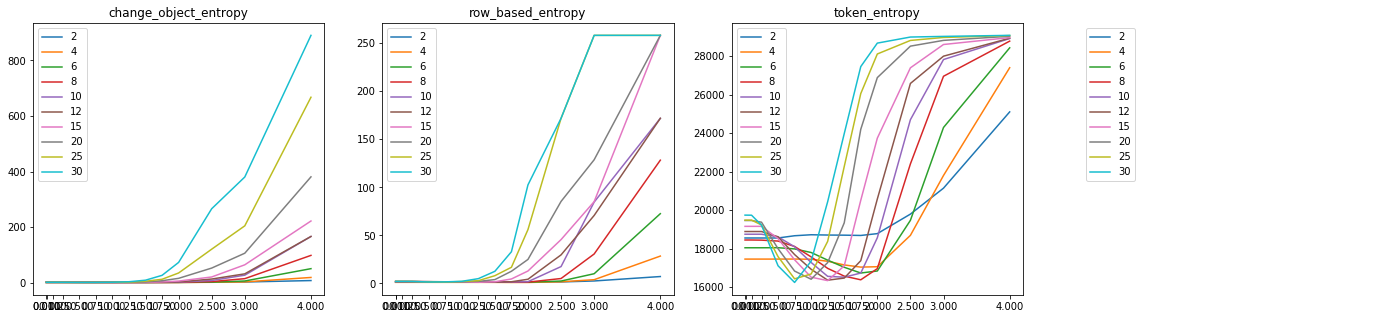

In [23]:
_df = evaluation_df.reset_index()

cols = [
    'change_object_entropy', 'row_based_entropy', 'token_entropy',
]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24,5))
for i, column in enumerate(cols):
    if column in _df.columns:
        _ax = axes[i]
        _ax.xaxis.label.set_visible(False)

        for name2, subdf2 in _df.groupby(['context']): 
            subdf2.plot(x = 'eps', y=column, ax=_ax, label=str(name2), title=column,  xticks=eps_array)

handles, labels = _ax.get_legend_handles_labels()
axes[3].legend(handles, labels, loc='upper left')
axes[3].axis('off')
